<a href="https://colab.research.google.com/github/3lueLightning/tutorials/blob/main/rag_development_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
! pip install -q langchain langchain_community tiktoken langchain_openai langchain_text_splitters docarray langsmith

# Loading the data
For this example we will be extracting the a list of the top 100 best movies of all time according to the magazin Empire. Let me know in the comments if you agree with the list ;)

In [4]:
import os
from langchain_community.document_loaders import WebBaseLoader

# to improve our chances of not being blocked online we set a user agent to
# out crawler. This means
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"


## Test connection

Testing that we can access the page with a simple HTTP request (working as a combination of `request.get` and `bs4.BeautifulSoup`), more info [here](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)

In [5]:
MOVIES_URL = "https://www.empireonline.com/movies/features/best-movies-2/"

full_page = WebBaseLoader(MOVIES_URL).load()
if not full_page:
  print("The page didn't load, but no worries we have a backup ;)")
else:
  print(full_page[0].page_content[:200])

'The 100 Best Movies Of All Time | Movies | %%channel_name%% MoviesReviewsNewsFeaturesTVGamingPodcastsEmpire VIPShoppingEmpire MagazineSubscribeManage My SubscriptionNewsletterHome|Movies|FeaturesThe 1'

## Get data

SoupStainers allow us to extract information from a html without have to load everything in memory and then doing a find_all making it a more efficient option, more info [here](https://medium.com/codex/using-beautiful-soups-soupstrainer-to-save-time-and-memory-when-web-scraping-ea1dbd2e886f)

In [109]:
def is_target_element(elem, attrs):
    # get the movie description
    div_class = "listicleItem_listicle-item__content__Lxn1Y"
    div_mask = (elem == "div" and attrs.get("class") == div_class)
    # get the movie title
    h3_class = "listicleItem_listicle-item__title__BfenH"
    h3_mask = (elem == "h3" and attrs.get("class") == h3_class)
    return div_mask or h3_mask

strainer = SoupStrainer(is_target_element)


movie_scraper = WebBaseLoader(
    MOVIES_URL,
    bs_kwargs = {
        "parse_only": strainer
    }
)

movie_reviews_raw = movie_scraper.load()

In [100]:
from bs4 import SoupStrainer

def is_target_element(tag):
    # get the movie title
    h3_class = "listicleItem_listicle-item__title__BfenH"
    h3_mask = (tag.name == "h3" and tag.get("class") == [h3_class])
    # get the movie description
    div_class = "listicleItem_listicle-item__content__Lxn1Y"
    div_mask = (tag.name == "div" and tag.get("class") == [div_class])
    return h3_mask or div_mask

strainer = SoupStrainer(is_target_element)

try:
  movie_scraper = WebBaseLoader(
      MOVIES_URL,
      bs_kwargs = {
          "parse_only": strainer
      }
  )

  movie_reviews_raw = movie_scraper.load()
except:
  movie_reviews_raw = []

In [122]:
with open("movie_reviews_raw.pkl", "wb") as file:
  pickle.dump(movie_reviews_raw, file)

In [62]:
if (
    not movie_reviews_raw
    or movie_reviews_raw[0].page_content != "100 Reservoir Dogs\nMaking"
):
  import pickle
  import urllib
  BACKUP_MOVIES_PKL_URL = "https://tutorials-public.s3.eu-west-1.amazonaws.com/movie_reviews_raw.pkl"
  with urllib.request.urlopen(BACKUP_MOVIES_PKL_URL) as response:
      movie_reviews_raw = pickle.load(response)

# Process data

All the movie reviews come as a single document, but we want to split them and remove the links to the full movie reviews at the end of each block

In [117]:
from langchain.docstore.document import Document

def split_movies(page: Document) -> list[Document]:
  movie_reviews = page.page_content.strip().split("\n\n")
  movie_reviews = [reviews.split("\n")[:2] for reviews in movie_reviews]
  movie_reviews = [
      "\n".join([p.strip() for p in reviews])
      for reviews in movie_reviews
  ]
  movie_docs = [
      Document(review, metadata={**page.metadata, "rank": i})
      for review, i in zip(movie_reviews, range(100, 0, -1))
  ]
  return movie_docs

In [118]:
movie_reviews = split_movies(movie_reviews_raw[0])
movie_reviews[0]

Document(page_content="100 Reservoir Dogs\nMaking his uber cool and supremely confident directorial debut, Quentin Tarantino hit audiences with a terrific twist on the heist-gone-wrong thriller. For the most part a single location chamber piece, Reservoir Dogs delights in ricocheting the zing and fizz of its dialogue around its gloriously —and indeed gore-iously) — intense setting, with the majority of the movie's action centring around one long and incredibly bloody death scene. Packing killer lines, killer needledrops, and killer, er, killers too, not only is this a rollicking ride in its own right, but it also set the blueprint for everything we've come to expect from a Tarantino joint. Oh, and by the way: Nice Guy Eddie was shot by Mr. White. Who fired twice. Case closed.", metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 100})

## Data Analysis
Let's check there are any issues with the data and understand how much we will be charged by OpenAI taking into account that we are charge by token sent to their API. There way of tokenizing the by OpenAI is via tiktoken.


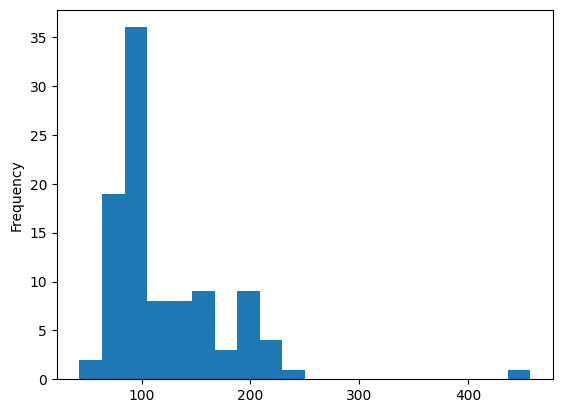

In [80]:
import tiktoken
import pandas as pd


def count_tokens(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_counts = pd.Series(movie_reviews).apply(
    lambda doc: count_tokens(doc.page_content, "cl100k_base")
)
token_counts.plot.hist(bins=20);

We notice that there is one movie with a lot more tokens then the other. So we check that there are no issues.

In [11]:
import numpy as np

movie_reviews[np.argmax(token_counts)].page_content

"A wizard is never late. Nor is he early. He arrives precisely when he... well, you know the rest. It might have taken 20 years for Peter Jackson's plucky fantasy to clamber, Mount-Doom-style, to the very pinnacle of our greatest-movies pantheon. But here it is, brighter and more resplendent than ever.The Fellowship Of The Ring contains so much movie. Even at the halfway point, as the characters take a breather to bicker in Rivendell, you already feel sated, like you've experienced more thrills, more suspense, more jollity and ethereal beauty than a regular film could possibly muster up. But Jackson is only getting started. Onwards his adventure hustles, to the bravura dungeoneering of Khazad-dum, to the sinisterly serene glades of Lothlorien, to the final requiem for flawed Boromir amidst autumnal leaves. As Fellowship thrums to its conclusion, finally applying the brakes with a last swell of Howard Shore's heavenly score, you're left feeling euphoric, bereft and hopeful, all at the s

# Set up database

## Embedding
Creating an embedding using Open API's models, more infor [here](https://platform.openai.com/docs/guides/embeddings)

In [12]:
import getpass
OPENAI_API_KEY = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

··········


In [23]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL_NAME = "text-embedding-3-large"

embeder = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# testing embeding
test_embedding = embeder.embed_query("What is 'Hello World'?")
print(test_embedding[:5])
print(f"the model {EMBEDDING_MODEL_NAME} generates embeddings of length: {len(test_embedding)}")

[-0.015830961987376213, -0.05633659288287163, -0.01440573763102293, 0.01969003491103649, -0.017862822860479355]
the model text-embedding-3-large generates embeddings of length: 3072


## Insertion in Index

In [74]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
# docarray was imported earlier to avoid an error when using from_documents()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    length_function=len,
)

text_splitter.split_text(movie_reviews[5].page_content)

["A high school drama with a time traveling, tangential universe threading, sinister rabbit featuring twist, Richard Kelly's deliberately labyrinthine opus was always destined for cult classic status. A certifiable flop upon its theatrical release, Kelly's film was one of the early beneficiaries of physical media's move to DVD, with the movie gaining a fandom in film obsessives who could pause, play, and skip back and forth through it at will. Any attempt to synopsise the movie is a fool's errand, but there's more than a hint of\xa0It's A Wonderful Life in the way we see Donnie (Jake Gyllenhaal, in a star-making turn) experiencing how the world would be worse off if he survives the jet engine that mysteriously crashes through his bedroom. That the film, with all its heavy themes and brooding atmosphere, manages to eventually land on a note of overwhelming optimism is a testament to Kelly's mercurial moviemaking. A mad world (mad world) Donnie Darko's may be, but it's also one that cont

In [24]:
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch


index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeder,
    text_splitter=text_splitter,
).from_documents(movie_reviews)

In [91]:
retriever = index.vectorstore.as_retriever()
relevant_movies = retriever.vectorstore.similarity_search(
    "Can you recommend me an adventure movie?"
)
for doc in relevant_movies:
  print(doc.page_content)

You voted... wisely. There may only be 12 years' difference between Harrison Ford and Sean Connery, but it's hard to imagine two better actors to play a bickering father and son, off on a globetrotting, Nazi-bashing, mythical mystery tour. After all, you've got Spielberg/Lucas' own version of James Bond... And the original Bond himself.
The film-maker go-to movie du jour. Gareth Edwards cited Coppola's vivid and visceral jungle trek as a major influence on Rogue One; Jordan Vogt-Roberts drew from it extensively for Kong: Skull Island, and Matt Reeves sees War For The Planet Of The Apes as his own simian-related tribute. Hardly surprising; it's both a visually rich war movie and also a powerfully resonant journey into the darkest recesses of the human soul.
If you only ever see one David Lean movie... well, don't. Watch as many as you can. But if you really insist on only seeing one David Lean movie, then make sure it's Lawrence Of Arabia, the movie that put both the "sweeping" and the 

# LLM

In [85]:
from langchain_openai import ChatOpenAI

LLM_MODEL_NAME = "gpt-3.5-turbo"
llm = ChatOpenAI(
    model=LLM_MODEL_NAME,
    # higher temperature means more orginal answers so we set it to the max
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# testing that the LLM works
llm.invoke("Hey how are you GPTie?")

AIMessage(content="Hello! I'm just a language model AI so I don't have feelings, but I'm here and ready to help. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 15, 'total_tokens': 47}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6866b21a-d221-4ea9-b47d-15464ed1f459-0', usage_metadata={'input_tokens': 15, 'output_tokens': 32, 'total_tokens': 47})

In [ ]:
from langchain import hub

hub.pull()

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

combine_docs_chain = create_stuff_documents_chain(llm, chat_template)
chat_chain = create_retrieval_chain(full_article_retriever, combine_docs_chain)

chat_answer = chat_chain.invoke({"input": EASY_QUESTION})

In [ ]:
from langsmith import Client